In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Aug 30 16:29:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             52W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
# Environment setup

!nvidia-smi -L || true


!pip -q uninstall -y peft bitsandbytes albumentations albucore opencv-python opencv-python-headless || true

# Compatible versions
!pip -q install "transformers==4.41.2" "decord==0.6.0" "torchmetrics==1.4.0" "scikit-learn==1.5.1" \
                albumentations==1.4.8 albucore==0.0.14 opencv-python-headless==4.10.0.84 --no-cache-dir

import os, math, random, json, glob, time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.cuda.amp import autocast, GradScaler

import decord
decord.bridge.set_bridge('native')

from transformers import (
    AutoImageProcessor,
    TimesformerForVideoClassification,
    get_linear_schedule_with_warmup,
)

from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score

import albumentations as A
from albumentations.core.composition import ReplayCompose

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)


GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-d3f43ace-754d-258c-0678-e30d513b7372)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 124.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 307.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 288.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 339.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 226.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 311.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.1 which is incompatible.
Dev

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DRIVE_DATA_ROOT = "/content/drive/MyDrive/Moo/Annotations"

# Copy to local SSD for faster I/O
COPY_TO_LOCAL = False
LOCAL_DATA_ROOT = "/content/Dataset"
if COPY_TO_LOCAL:
    os.makedirs(LOCAL_DATA_ROOT, exist_ok=True)
    !rsync -ah --info=progress2 "{DRIVE_DATA_ROOT}/" "{LOCAL_DATA_ROOT}/"
    DATA_ROOT = LOCAL_DATA_ROOT
else:
    DATA_ROOT = DRIVE_DATA_ROOT

TRAIN_DIR = os.path.join(DATA_ROOT, "train")
VAL_DIR   = os.path.join(DATA_ROOT, "val")

# Classes
CLASSES = [
    "Drinking",
    "Feeding & Lying",
    "Feeding & Standing",
    "Lying",
    "Ruminating & Lying",
    "Ruminating & Standing",
    "Standing",
]
label2id = {c:i for i,c in enumerate(CLASSES)}
id2label = {i:c for c,i in label2id.items()}

# Hyperparams
NUM_FRAMES      = 12
IMAGE_SIZE      = 224
BATCH_SIZE      = 4
ACCUM_STEPS     = 4
EPOCHS          = 20
LR              = 3e-5
WEIGHT_DECAY    = 0.01
WARMUP_RATIO    = 0.1
MAX_GRAD_NORM   = 1.0
MIXED_PRECISION = True
PATIENCE        = 4
NUM_WORKERS     = 2

# Rebalancing
BALANCING_STRATEGY = "sampler"
SAMPLER_NUM_SAMPLES = 8000

# Model
CKPT = "facebook/timesformer-base-finetuned-k400"

# Save dir
save_dir = "/content/drive/MyDrive/Models/timesformer-cows2"
os.makedirs(save_dir, exist_ok=True)

print("Classes:", label2id)
print("Data root:", DATA_ROOT)
print("Balancing:", BALANCING_STRATEGY, "| epoch draws:", SAMPLER_NUM_SAMPLES)

Classes: {'Drinking': 0, 'Feeding & Lying': 1, 'Feeding & Standing': 2, 'Lying': 3, 'Ruminating & Lying': 4, 'Ruminating & Standing': 5, 'Standing': 6}
Data root: /content/drive/MyDrive/Moo/Annotations
Balancing: sampler | epoch draws: 8000


In [ ]:
# List videos

def list_videos(root_dir, classes):
    items = []
    for cls in classes:
        cls_dir = Path(root_dir) / cls
        patterns = ["*.mp4", "*.MP4", "*.mkv", "*.MOV", "*.mov"]
        vids = []
        for p in patterns:
            vids.extend(glob.glob(str(cls_dir / p)))
        items.extend([(v, label2id[cls]) for v in vids])
    return items

train_items = list_videos(TRAIN_DIR, CLASSES)
val_items   = list_videos(VAL_DIR,   CLASSES)
print(f"Found {len(train_items)} train and {len(val_items)} val clips.")
assert len(train_items) > 0 and len(val_items) > 0


Found 2748 train and 689 val clips.


In [ ]:
# Frame sampling and decoding

def sample_indices(num_frames_in_video, num_frames_needed):
    if num_frames_in_video <= num_frames_needed:
        return np.linspace(0, num_frames_in_video-1, num_frames_needed).astype(int)
    ticks = np.linspace(0, num_frames_in_video-1, num_frames_needed+1)
    idxs = []
    for i in range(num_frames_needed):
        s = int(math.floor(ticks[i]))
        e = int(math.floor(ticks[i+1]))
        if e <= s: e = s + 1
        idxs.append(random.randint(s, max(s, e-1)))
    return np.array(idxs)

def decode_video(path, num_frames=NUM_FRAMES):
    vr = decord.VideoReader(path)
    idxs = sample_indices(len(vr), num_frames)
    batch = vr.get_batch(idxs)   # decord NDArray (T,H,W,C)
    frames = batch.asnumpy()     # uint8
    return [frames[i] for i in range(frames.shape[0])]

In [ ]:
# Augmentation, Dataset, Collate

image_processor = AutoImageProcessor.from_pretrained(CKPT)

# Mild, clip-consistent augmentation
train_augment = ReplayCompose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(0.15, 0.15, p=0.3),
    A.HueSaturationValue(5, 10, 10, p=0.2),
    A.GaussianBlur(blur_limit=(3,5), p=0.15),
    A.GaussNoise(var_limit=(5.0, 15.0), p=0.15),
], p=1.0)
val_augment = None

class VideoDataset(Dataset):
    def __init__(self, items, augmenter=None):
        self.items = items
        self.augmenter = augmenter

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        path, label = self.items[idx]
        frames = decode_video(path, NUM_FRAMES)  # list of HWC uint8
        if self.augmenter is not None:
            first = self.augmenter(image=frames[0])
            replay = first["replay"]
            frames = [ReplayCompose.replay(replay, image=f)["image"] for f in frames]
        return {"video": frames, "label": label, "path": path}

def collate_fn(batch):
    videos = [b["video"] for b in batch]
    labels = torch.tensor([b["label"] for b in batch], dtype=torch.long)
    proc = image_processor(videos, return_tensors="pt")  # (B,3,T,H,W)
    return {"pixel_values": proc["pixel_values"], "labels": labels}

train_ds = VideoDataset(train_items, augmenter=train_augment)
val_ds   = VideoDataset(val_items,   augmenter=val_augment)

/usr/local/lib/python3.12/dist-packages/albumentations/core/composition.py:164: UserWarning: GaussNoise could work incorrectly in ReplayMode for other input data because its' params depend on targets.
  t.set_deterministic(flag, save_key)


In [ ]:
# WeightedRandomSampler

from torch.utils.data import WeightedRandomSampler

# Per class counts from train set
counts = np.zeros(len(CLASSES), dtype=np.int64)
for _, y in train_items: counts[y] += 1
print("Original train counts:", dict(zip(CLASSES, counts)))

# Random oversampling proportional to inverse counts
w_per_class = np.zeros_like(counts, dtype=float)
nz = counts > 0
w_per_class[nz] = 1.0 / counts[nz]

# Normalize for nicer scales
w_per_class = w_per_class / (w_per_class.mean() if w_per_class.mean() > 0 else 1.0)

sample_weights = [w_per_class[y] for _, y in train_items]
num_samples = int(SAMPLER_NUM_SAMPLES) if SAMPLER_NUM_SAMPLES else len(train_items)

sampler = WeightedRandomSampler(
    torch.DoubleTensor(sample_weights),
    num_samples=num_samples,
    replacement=True
)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,               # sampler controls the draw
    sampler=sampler,
    num_workers=NUM_WORKERS, pin_memory=True,
    persistent_workers=(NUM_WORKERS>0),
    prefetch_factor=(2 if NUM_WORKERS>0 else None),
    collate_fn=collate_fn, drop_last=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True,
    persistent_workers=(NUM_WORKERS>0),
    prefetch_factor=(2 if NUM_WORKERS>0 else None),
    collate_fn=collate_fn
)

# Per epoch counts
def summarize_effective_counts_sampler(sampler, train_items):
    idxs = list(iter(sampler))  # indices drawn for one epoch; no decoding
    eff = np.zeros(len(CLASSES), dtype=int)
    for i in idxs:
        _, y = train_items[int(i)]
        eff[y] += 1
    return eff, len(idxs)

eff_counts, total = summarize_effective_counts_sampler(sampler, train_items)
df_counts = pd.DataFrame({
    "class": CLASSES,
    "original_count": counts,
    "effective_count_per_epoch": eff_counts
})
df_counts["oversample_gain"] = df_counts["effective_count_per_epoch"] - df_counts["original_count"]
df_counts.loc["TOTAL"] = ["—", counts.sum(), eff_counts.sum(), eff_counts.sum()-counts.sum()]
print(f"Epoch draws (target): {num_samples}")
display(df_counts)


Original train counts: {'Drinking': np.int64(160), 'Feeding & Lying': np.int64(78), 'Feeding & Standing': np.int64(588), 'Lying': np.int64(888), 'Ruminating & Lying': np.int64(496), 'Ruminating & Standing': np.int64(279), 'Standing': np.int64(259)}
Epoch draws (target): 8000


,class,original_count,effective_count_per_epoch,oversample_gain
0,Drinking,160,1103,943
1,Feeding & Lying,78,1172,1094
2,Feeding & Standing,588,1088,500
3,Lying,888,1181,293
4,Ruminating & Lying,496,1179,683
5,Ruminating & Standing,279,1133,854
6,Standing,259,1144,885
TOTAL,—,2748,8000,5252


In [ ]:
# Model & Loss

model = TimesformerForVideoClassification.from_pretrained(
    CKPT,
    num_labels=len(CLASSES),
    ignore_mismatched_sizes=True,
    label2id=label2id,
    id2label=id2label,
)
model.config.num_frames = NUM_FRAMES
model.config.image_size = IMAGE_SIZE
model.to(device)

# Use plain CE
criterion = nn.CrossEntropyLoss()


Some weights of TimesformerForVideoClassification were not initialized from the model checkpoint at facebook/timesformer-base-finetuned-k400 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Optimizer, Scheduler, AMP

num_update_steps_per_epoch = math.ceil(len(train_loader) / ACCUM_STEPS)
num_training_steps = EPOCHS * num_update_steps_per_epoch
num_warmup_steps = int(WARMUP_RATIO * num_training_steps)

optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)
scaler = GradScaler(enabled=(device.type == "cuda" and MIXED_PRECISION))

print(f"Training steps: {num_training_steps} (warmup {num_warmup_steps})")


/tmp/ipython-input-3063864971.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device.type == "cuda" and MIXED_PRECISION))


Training steps: 10000 (warmup 1000)


In [ ]:
# Train / Validate (early stopping + save best)

history = {"epoch": [], "train_loss": [], "val_loss": [], "val_acc": [], "val_f1": []}
best_val_loss = float('inf')
best_val_acc  = 0.0
stale = 0
global_step = 0

def evaluate(model, loader):
    model.eval()
    acc_metric = MulticlassAccuracy(num_classes=len(CLASSES)).to(device)
    f1_metric  = MulticlassF1Score(num_classes=len(CLASSES), average="macro").to(device)
    total_loss, n = 0.0, 0
    with torch.no_grad():
        for batch in loader:
            pixel_values = batch["pixel_values"].to(device, non_blocking=True)
            labels       = batch["labels"].to(device, non_blocking=True)
            logits = model(pixel_values=pixel_values).logits
            loss = criterion(logits, labels)
            total_loss += loss.item() * labels.size(0)
            n += labels.size(0)
            acc_metric.update(logits, labels)
            f1_metric.update(logits, labels)
    return total_loss / max(1,n), acc_metric.compute().item(), f1_metric.compute().item()

for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss, num_train_examples = 0.0, 0
    optimizer.zero_grad(set_to_none=True)
    t0 = time.time()

    for step, batch in enumerate(train_loader, start=1):
        pixel_values = batch["pixel_values"].to(device, non_blocking=True)
        labels       = batch["labels"].to(device, non_blocking=True)

        with autocast(enabled=(device.type == "cuda" and MIXED_PRECISION)):
            logits = model(pixel_values=pixel_values).logits
            loss = criterion(logits, labels) / ACCUM_STEPS

        scaler.scale(loss).backward()
        if step % ACCUM_STEPS == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
            scaler.step(optimizer); scaler.update()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()
            global_step += 1

        running_loss += loss.item() * labels.size(0)
        num_train_examples += labels.size(0)

    val_loss, val_acc, val_f1 = evaluate(model, val_loader)
    train_loss = running_loss / max(1, num_train_examples)
    dt = time.time() - t0
    print(f"Epoch {epoch:02d}/{EPOCHS}  train_loss={train_loss:.4f}  val_loss={val_loss:.4f}  "
          f"val_acc={val_acc:.4f}  val_f1={val_f1:.4f}  ({dt/60:.1f} min)")

    # Log + persist history
    history["epoch"].append(epoch)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["val_f1"].append(val_f1)
    pd.DataFrame(history).to_csv(os.path.join(save_dir, "training_history.csv"), index=False)

    # Save best by val_acc
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        model.save_pretrained(save_dir)
        image_processor.save_pretrained(save_dir)
        with open(os.path.join(save_dir, "labels.json"), "w") as f:
            json.dump({"label2id": label2id, "id2label": id2label}, f, indent=2)
        print(f"✅ Saved new best to {save_dir} (val_acc={val_acc:.4f})")

    # Early stopping by val_loss
    if val_loss + 1e-6 < best_val_loss:
        best_val_loss = val_loss
        stale = 0
    else:
        stale += 1
        if stale >= PATIENCE:
            print("⏹️ Early stopping triggered.")
            break

    # Always keep a last checkpoint
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        "label2id": label2id,
        "id2label": id2label,
        "num_frames": NUM_FRAMES,
    }, os.path.join(save_dir, "last.pt"))

print("Training complete.")


/usr/local/lib/python3.12/dist-packages/albumentations/core/composition.py:164: UserWarning: GaussNoise could work incorrectly in ReplayMode for other input data because its' params depend on targets.
  t.set_deterministic(flag, save_key)
/usr/local/lib/python3.12/dist-packages/albumentations/core/composition.py:164: UserWarning: GaussNoise could work incorrectly in ReplayMode for other input data because its' params depend on targets.
  t.set_deterministic(flag, save_key)
/usr/local/lib/python3.12/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  return torch.tensor(value)
/usr/local/lib/python3.12/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarr

Epoch 01/20  train_loss=0.2392  val_loss=0.6169  val_acc=0.7422  val_f1=0.7340  (48.7 min)
✅ Saved new best to /content/drive/MyDrive/Models/timesformer-cows2 (val_acc=0.7422)
Epoch 02/20  train_loss=0.0573  val_loss=0.5641  val_acc=0.7685  val_f1=0.7754  (35.4 min)
✅ Saved new best to /content/drive/MyDrive/Models/timesformer-cows2 (val_acc=0.7685)
Epoch 03/20  train_loss=0.0373  val_loss=0.7374  val_acc=0.7804  val_f1=0.7900  (34.2 min)
✅ Saved new best to /content/drive/MyDrive/Models/timesformer-cows2 (val_acc=0.7804)
Epoch 04/20  train_loss=0.0215  val_loss=0.7412  val_acc=0.7758  val_f1=0.7868  (34.0 min)
Epoch 05/20  train_loss=0.0135  val_loss=0.8321  val_acc=0.8188  val_f1=0.8221  (33.8 min)
✅ Saved new best to /content/drive/MyDrive/Models/timesformer-cows2 (val_acc=0.8188)
Epoch 06/20  train_loss=0.0100  val_loss=0.7418  val_acc=0.8225  val_f1=0.8361  (33.9 min)
✅ Saved new best to /content/drive/MyDrive/Models/timesformer-cows2 (val_acc=0.8225)
⏹️ Early stopping triggered.


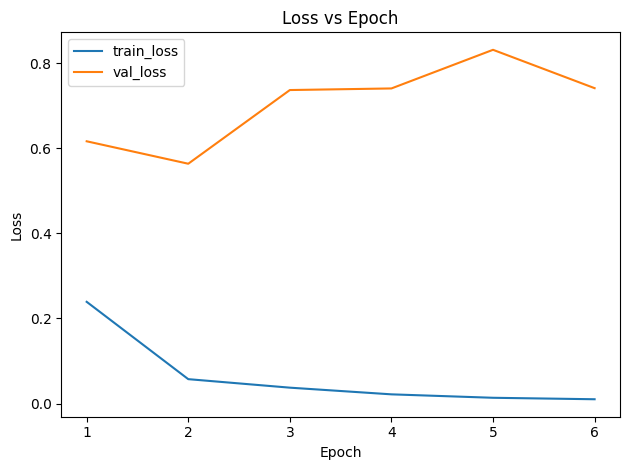

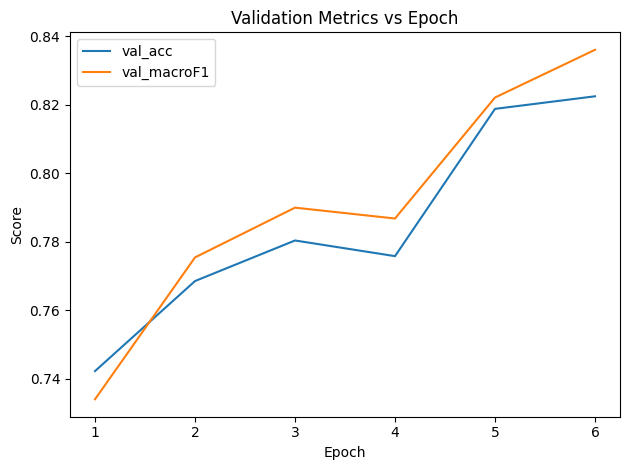

In [ ]:
# Curves: Loss / Macro-F1

hist_df = pd.DataFrame(history)

plt.figure()
plt.plot(hist_df["epoch"], hist_df["train_loss"], label="train_loss")
plt.plot(hist_df["epoch"], hist_df["val_loss"], label="val_loss")
plt.title("Loss vs Epoch"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
plt.tight_layout(); plt.savefig(os.path.join(save_dir, "loss_curve.png"), dpi=150); plt.show()

plt.figure()
plt.plot(hist_df["epoch"], hist_df["val_acc"], label="val_acc")
plt.plot(hist_df["epoch"], hist_df["val_f1"], label="val_macroF1")
plt.title("Validation Metrics vs Epoch"); plt.xlabel("Epoch"); plt.ylabel("Score"); plt.legend()
plt.tight_layout(); plt.savefig(os.path.join(save_dir, "metrics_curve.png"), dpi=150); plt.show()


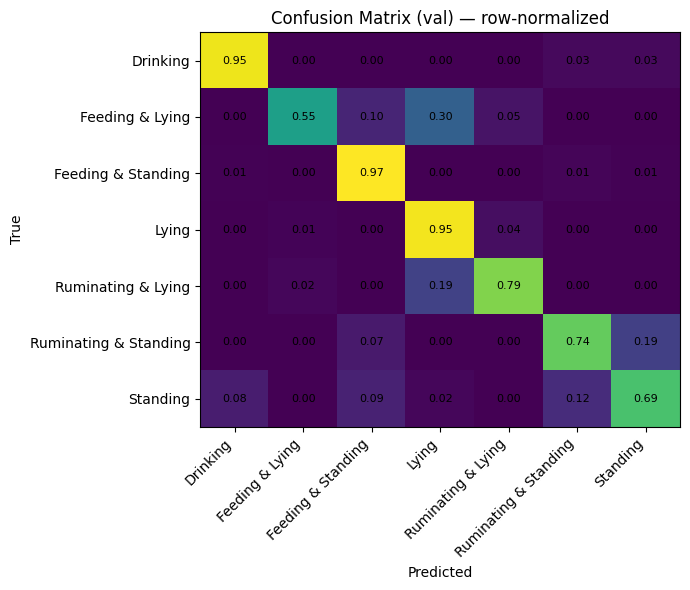

,precision,recall,f1-score,support
Drinking,0.863636,0.950000,0.904762,40.000000
Feeding & Lying,0.733333,0.550000,0.628571,20.000000
Feeding & Standing,0.917197,0.972973,0.944262,148.000000
Lying,0.872428,0.954955,0.911828,222.000000
Ruminating & Lying,0.915888,0.790323,0.848485,124.000000
Ruminating & Standing,0.825397,0.742857,0.781955,70.000000
Standing,0.750000,0.692308,0.720000,65.000000
accuracy,0.870827,0.870827,0.870827,0.870827
macro avg,0.839697,0.807631,0.819980,689.000000
weighted avg,0.868990,0.870827,0.867471,689.000000


              Drinking: recall=0.950
       Feeding & Lying: recall=0.550
    Feeding & Standing: recall=0.973
                 Lying: recall=0.955
    Ruminating & Lying: recall=0.790
 Ruminating & Standing: recall=0.743
              Standing: recall=0.692


In [ ]:
# Confusion matrix + per-class report

@torch.no_grad()
def collect_predictions(loader):
    model.eval()
    all_probs, all_preds, all_labels = [], [], []
    for batch in loader:
        pixel_values = batch["pixel_values"].to(device, non_blocking=True)
        labels       = batch["labels"].to(device, non_blocking=True)
        logits = model(pixel_values=pixel_values).logits
        probs  = torch.softmax(logits, dim=-1)
        preds  = torch.argmax(probs, dim=-1)
        all_probs.append(probs.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
    return (np.concatenate(all_probs, axis=0),
            np.concatenate(all_preds, axis=0),
            np.concatenate(all_labels, axis=0))

y_scores, y_pred, y_true = collect_predictions(val_loader)

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(CLASSES))))
cm_norm = cm.astype(float) / np.clip(cm.sum(axis=1, keepdims=True), 1, None)

plt.figure(figsize=(7,6))
plt.imshow(cm_norm, aspect="auto")
plt.title("Confusion Matrix (val) — row-normalized")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(ticks=np.arange(len(CLASSES)), labels=CLASSES, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(CLASSES)), labels=CLASSES)
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center", fontsize=8)
plt.tight_layout(); plt.savefig(os.path.join(save_dir, "confusion_matrix.png"), dpi=150); plt.show()

report = classification_report(y_true, y_pred, target_names=CLASSES, digits=3, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(os.path.join(save_dir, "classification_report.csv"))
display(report_df)

per_class_recall = (cm.diagonal() / np.clip(cm.sum(axis=1), 1, None))
for cls, rec in zip(CLASSES, per_class_recall):
    print(f"{cls:>22s}: recall={rec:.3f}")


In [ ]:
# mAP

num_classes = len(CLASSES)
y_true_bin = np.eye(num_classes)[y_true]  # (N, C)

aps = []
for c in range(num_classes):
    ap_c = average_precision_score(y_true_bin[:, c], y_scores[:, c])
    aps.append(ap_c)
    print(f"AP[{CLASSES[c]}] = {100*ap_c:.2f}%")
mAP_macro = float(np.mean(aps))
print(f"\n==> mAP (macro) on val: {100*mAP_macro:.2f}%")

pd.DataFrame({"class": CLASSES, "AP": aps, "AP_%": [100*a for a in aps]}).to_csv(
    os.path.join(save_dir, "per_class_AP.csv"), index=False
)


AP[Drinking] = 96.04%
AP[Feeding & Lying] = 67.33%
AP[Feeding & Standing] = 98.41%
AP[Lying] = 94.31%
AP[Ruminating & Lying] = 92.60%
AP[Ruminating & Standing] = 83.35%
AP[Standing] = 80.68%

==> mAP (macro) on val: 87.53%
